In [32]:
# import packages
from matplotlib import rcParams
rcParams['figure.dpi'] = 120
rcParams["savefig.dpi"] = 200
rcParams['figure.facecolor'] = 'w'

from astropy.io import fits
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd

from lmfit import Model, minimize, Parameters, fit_report
from lmfit.models import LinearModel

import os
import warnings
warnings.filterwarnings('ignore')


# path joining version for other paths
notebook_path = os.path.abspath('h3p_map_order37.ipynb' + "/../../")
filepath = os.path.join(os.path.dirname(notebook_path), 'spec/')

# count number of fits files in folder
filesize = len([name for name in os.listdir(filepath) if os.path.isfile(os.path.join(filepath, name))])

# load fits data
nirspec_data = []
nirspec_utc_list = []

start_nirspec = 22 # fits index start, min >= 1, max <= n
end_nirspec = 112 # fits index end, min >= n, max <= 999

# order37
for i in range(filesize):
    n = i + start_nirspec
    if n>= start_nirspec and n < 10:
        hdu_data = fits.getdata(filepath + 'order37/new_frame/jun02s000' + '{}_order37.fits'.format(n), ext=0)
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(n), ignore_missing_end=True)[0].header
        nirspec_data.append(hdu_data)
        nirspec_utc_list.append(hdu_header['UTC'])
    elif n>= 10 and n < 100:
        hdu_data = fits.getdata(filepath + 'order37/new_frame/jun02s00' + '{}_order37.fits'.format(n), ext=0)
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(n), ignore_missing_end=True)[0].header
        nirspec_data.append(hdu_data)
        nirspec_utc_list.append(hdu_header['UTC'])
    elif n >= 100 and n < end_nirspec: # fits index ends at 111
        hdu_data = fits.getdata(filepath + 'order37/new_frame/jun02s0' + '{}_order37.fits'.format(n), ext=0)
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(n), ignore_missing_end=True)[0].header
        nirspec_data.append(hdu_data)
        nirspec_utc_list.append(hdu_header['UTC'])
    elif n >= end_nirspec:
        break
nirspec_data_array = np.array(nirspec_data)
nirspec_utc = np.array(nirspec_utc_list)

# load waverange
waverange = fits.open(filepath + 'order37/' + 'waverange.fits', ignore_missing_end=True)[0].data

# load spectral resolution
R = 73194.84858495607

# obtain average flat field
average_flat_field = np.mean((nirspec_data_array[32-start_nirspec], 
                              nirspec_data_array[33-start_nirspec], 
                              nirspec_data_array[34-start_nirspec], 
                              nirspec_data_array[35-start_nirspec], 
                              nirspec_data_array[36-start_nirspec], 
                              nirspec_data_array[37-start_nirspec], 
                              nirspec_data_array[38-start_nirspec], 
                              nirspec_data_array[39-start_nirspec], 
                              nirspec_data_array[40-start_nirspec], 
                              nirspec_data_array[41-start_nirspec],), axis=0)


# obtain average flat lamp off
average_flat_lamp_off = np.mean((nirspec_data_array[22-start_nirspec], 
                                 nirspec_data_array[23-start_nirspec], 
                                 nirspec_data_array[24-start_nirspec],
                                 nirspec_data_array[25-start_nirspec], 
                                 nirspec_data_array[26-start_nirspec], 
                                 nirspec_data_array[27-start_nirspec], 
                                 nirspec_data_array[28-start_nirspec], 
                                 nirspec_data_array[29-start_nirspec], 
                                 nirspec_data_array[30-start_nirspec], 
                                 nirspec_data_array[31-start_nirspec],), axis=0)

# define normalization function
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

# define guassian function, credit to pen and pants IDL's Gaussfit in Python
def gaussian_fit(x, a0, a1, a2, a3, a4, a5): 
    """
    x = data array
    a0 = height of guassian
    a1 = pixel position of Gaussian peak
    a2 = width of Gaussian
    a3 = constant term
    a4 = linear term
    a5 = quadratic term
    
    note: fwhm = a2 * np.sqrt(2 * np.log(2)) * 2
    """
    z = (x - a1) / a2
    y = a0 * np.exp(-z**2 / a2) + a3 + a4 * x + a5 * x**2
    return y

# convert observation time (UTC) to seconds 
def fits_header_utc_to_second(fn):
    # fn = frame_number
    if fn >= start_nirspec and fn < 10:
        hdu_header = fits.open(filepath + 'jun02s000' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 10 and fn < 100:
        hdu_header = fits.open(filepath + 'jun02s00' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= 100 and fn < end_nirspec:
        hdu_header = fits.open(filepath + 'jun02s0' + '{}.fits'.format(fn), ignore_missing_end=True)[0].header
    elif fn >= end_nirspec:
        pass
    
    h = float(hdu_header['UTC'].split(':')[0])
    m = float(hdu_header['UTC'].split(':')[1])
    s = float(hdu_header['UTC'].split(':')[2])
    
    seconds = h * 3600 + m * 60 + s
    return seconds

# scale the sky frame using the equation on page 9 of Stallard_et_al_2019
def scale_sky_frame(fn_spec):
    """
    confirmed sky frames: 51, 59, 60, 72, 78, 79, 91, 103
    """
    if fn_spec > 51 and fn_spec < 59:
        fn_sky1 = 51 # frame number of sky1
        fn_sky2 = 59 # frame number of sky2
    elif fn_spec > 60 and fn_spec < 72:
        fn_sky1 = 60
        fn_sky2 = 72
    elif fn_spec > 72 and fn_spec < 78:
        fn_sky1 = 72
        fn_sky2 = 78
    elif fn_spec > 78 and fn_spec < 91:
        fn_sky1 = 79
        fn_sky2 = 91
    elif fn_spec > 91 and fn_spec < 103:
        fn_sky1 = 91
        fn_sky2 = 103

    sky1 = nirspec_data_array[fn_sky1-start_nirspec]
    sky2 = nirspec_data_array[fn_sky2-start_nirspec]

    t1 = fits_header_utc_to_second(fn_sky1) 
    t2 = fits_header_utc_to_second(fn_sky2)
    td = fits_header_utc_to_second(fn_spec)

    sky_final = sky1 * ((t2 - td) / (t2 - t1)) + sky2 * ((td - t1) / (t2 - t1))
    return sky_final

fn_spec = 61 #frame number of target spectra
sky_total = scale_sky_frame(fn_spec)

# remove sky background: (object - sky_frame)/(average_flat_field - average_flat_lamp_off)
target_spec = nirspec_data_array[fn_spec-start_nirspec]
sky_subtracted = (target_spec - sky_total) / (average_flat_field - average_flat_lamp_off)
sky_subtracted[sky_subtracted<0] = 0
sky_subtracted[sky_subtracted>0.8] = 0
pixel = np.linspace(0, np.size(sky_subtracted, 1), np.size(sky_subtracted, 1))

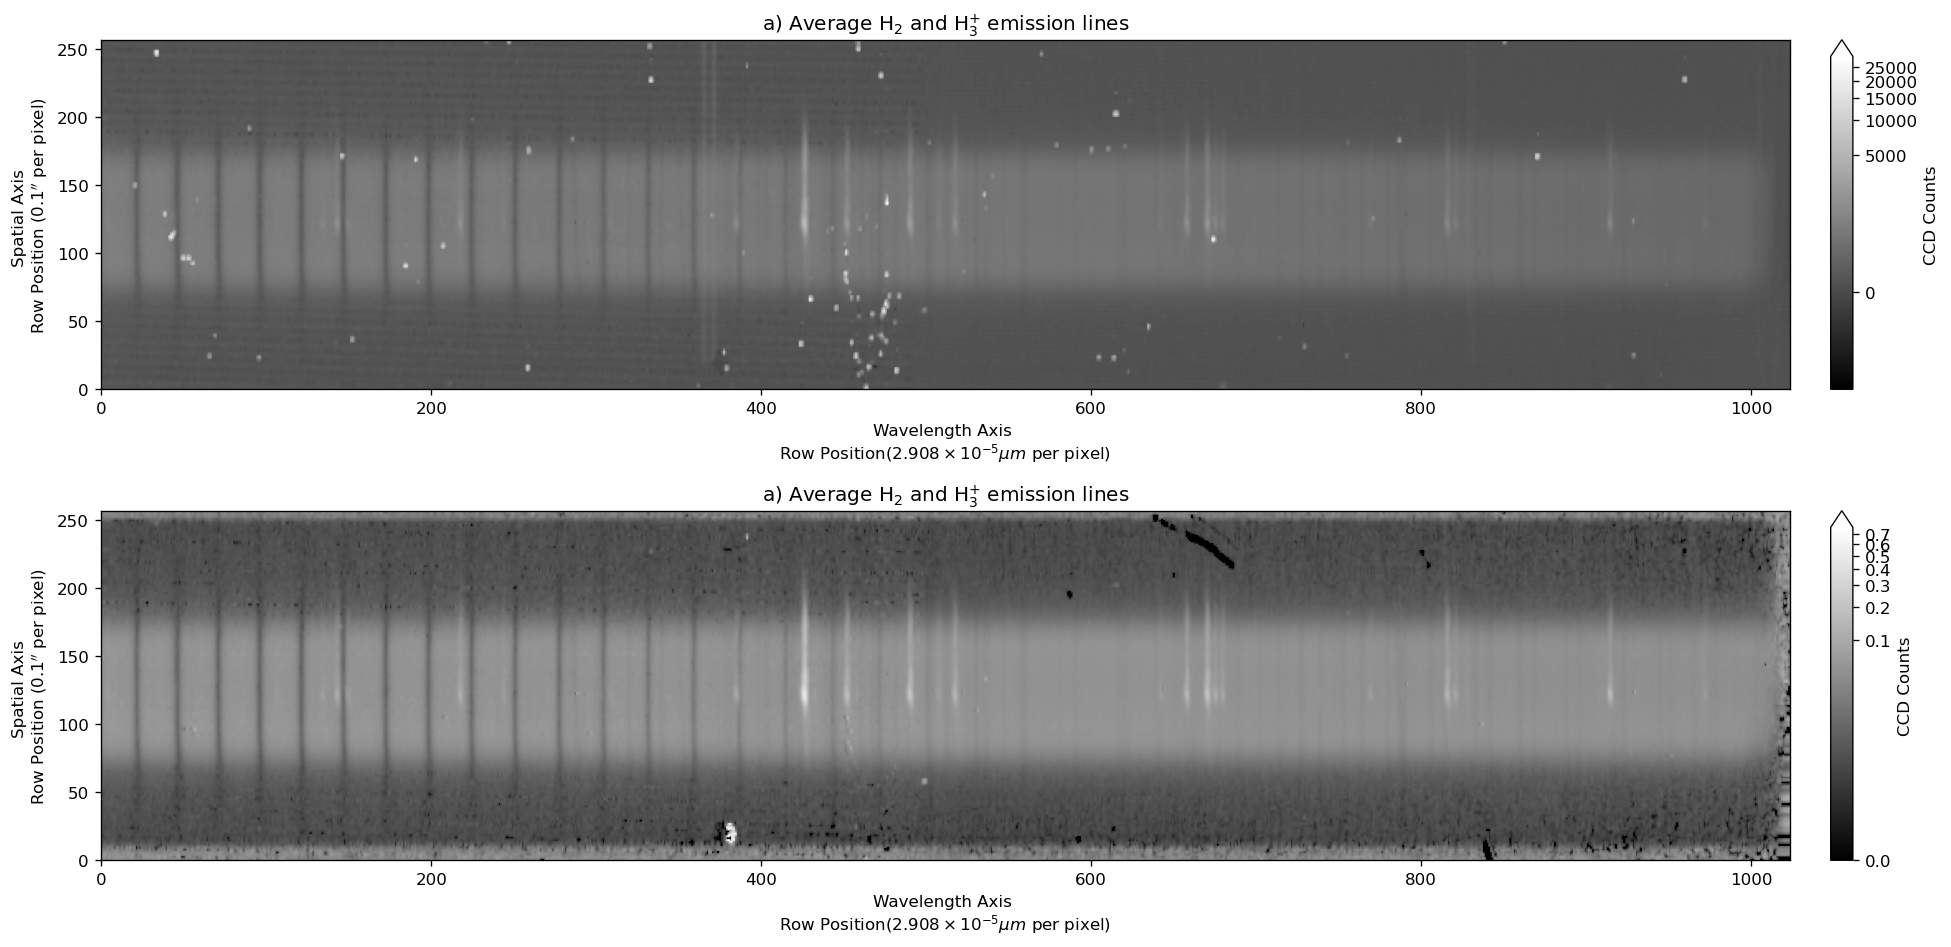

In [33]:
fig = plt.figure(figsize=(18,8), tight_layout=True)

fig.add_subplot(211)
plt.imshow(target_spec, aspect='auto', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.2))
# plt.axhline(y=60, c='white', ls='--', lw=0.3)
# plt.xlabel(r'Wavelength ($\mu$m)')
plt.xlabel('Wavelength Axis \nRow Position'+r'($2.908 \times 10^{-5} \mu m$ per pixel)')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)')
plt.ticklabel_format(useOffset=False)
plt.title('a) Average H$_2$ and H$_3^{+}$ emission lines')
plt.gca().invert_yaxis()
# plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Intensity (Wm$^{-2}$sr$^{-1}$)')
plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts')

fig.add_subplot(212)
plt.imshow(sky_subtracted, aspect='auto', cmap='gist_gray', norm=colors.PowerNorm(gamma=0.2))
# plt.axhline(y=60, c='white', ls='--', lw=0.3)
# plt.xlabel(r'Wavelength ($\mu$m)')
plt.xlabel('Wavelength Axis \nRow Position'+r'($2.908 \times 10^{-5} \mu m$ per pixel)')
plt.ylabel('Spatial Axis \nRow Position (0.1$^{\prime\prime}$ per pixel)')
plt.ticklabel_format(useOffset=False)
plt.title('a) Average H$_2$ and H$_3^{+}$ emission lines')
plt.gca().invert_yaxis()
# plt.colorbar(extend='max', aspect=15, pad=0.02, label=r'Intensity (Wm$^{-2}$sr$^{-1}$)')
plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts')

In [45]:
sky_subtracted.shape

(257, 1024)

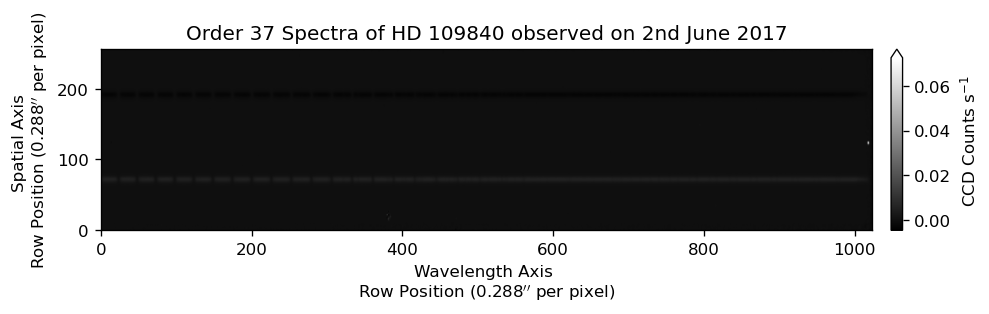

In [34]:
modeA = nirspec_data_array[43-start_nirspec] +\
        nirspec_data_array[46-start_nirspec] +\
        nirspec_data_array[47-start_nirspec] +\
        nirspec_data_array[50-start_nirspec]
modeB = nirspec_data_array[44-start_nirspec] +\
        nirspec_data_array[45-start_nirspec] +\
        nirspec_data_array[48-start_nirspec] +\
        nirspec_data_array[49-start_nirspec]                              
star_exp_time = 20

modeAB = ((modeA - modeB)/4)/(average_flat_field - average_flat_lamp_off)/star_exp_time

plt.figure(figsize=(10,2))
plt.imshow(modeAB, aspect='auto', cmap='gist_gray')
plt.title('Order 37 Spectra of HD 109840 observed on 2nd June 2017')
plt.xlabel('Wavelength Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
plt.ylabel('Spatial Axis \nRow Position (0.288$^{\prime\prime}$ per pixel)')
# plt.ticklabel_format(useOffset=False)
plt.gca().invert_yaxis()
plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts s$^{-1}$')
# plt.colorbar(extend='max', aspect=15, pad=0.02, label='CCD Counts')

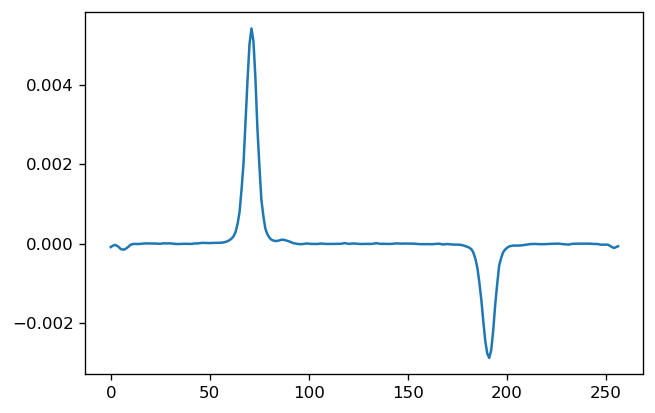

In [35]:
plt.plot(modeAB.T[800])

In [43]:
top = np.linspace(0, np.size(modeAB,0)-1, np.size(modeAB,0))[np.max(modeAB.T[200]) == modeAB.T[200]]
bot = np.linspace(0, np.size(modeAB,0)-1, np.size(modeAB,0))[np.min(modeAB.T[200]) == modeAB.T[200]]

(bot-top)[0]

120.0

In [44]:
bot,top

(array([191.]), array([71.]))

In [39]:
120/68*146

257.6470588235294